In [1]:
import torch
import torchvision
from torchvision.models import VGG11_Weights
import torchvision.transforms as transforms
from torch.utils.data import DataLoader as tf_dataloader
from torch.utils.data import Subset
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import numpy as np
import torch.optim as optim

In [2]:
transform = transforms.Compose([
    #transforms.Resize(256),
    #transforms.CenterCrop(224),
    transforms.ToTensor(), 
    transforms.Normalize((0.5,), (0.5,))
])

batch_size = 1

# Train data
trainset = torchvision.datasets.MNIST(
    root="./data", train=True, download=True, transform=transform
)
trainloader = tf_dataloader(
    trainset, batch_size=batch_size, shuffle=True, num_workers=2
)


# Test data
testset = torchvision.datasets.MNIST(
    root="./data", train=False, download=True, transform=transform
)
testloader = tf_dataloader(
    testset, batch_size=batch_size, shuffle=False, num_workers=2
)


In [3]:
# functions to show an image
def imshow(img):
    plt.figure(figsize=(2, 2))
    img = img / 2 + 0.5  # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.axis("off")
    plt.show()

tensor([2])


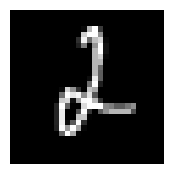

In [4]:
# get some random training images
dataiter = iter(trainloader)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

tensor([7])


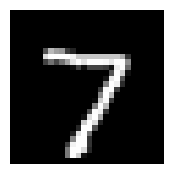

In [5]:
# get some random training images
dataiter = iter(testloader)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

In [6]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.layer1 = nn.Conv2d(in_channels=1, out_channels=4, kernel_size=3, stride=2, padding=0)
        
        self.layer2 = nn.Conv2d(in_channels=4, out_channels=8, kernel_size=3, stride=1, padding=0)
        
        self.layer3 = nn.Flatten()
        self.drop1 = nn.Dropout(p=0.2)
        
        self.fc1 = nn.Linear(in_features=968, out_features=512)
        self.fc2 = nn.Linear(in_features=512, out_features=10)
        

    def forward(self, x):
        
        self.x1 = F.relu(self.layer1(x))
        self.x2 = F.relu(self.layer2(self.x1))
        
        self.x3 = self.layer3(self.x2)
        self.x4 = self.drop1(self.x3)
        
        self.x5 = F.relu(self.fc1(self.x4))
        self.x6 = F.softmax(self.fc2(self.x5), dim = 1)
            
        return self.x3, self.x6

net = Net()

In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

In [8]:
epochs = 10
patience = 2  # Define the number of epochs to tolerate before early stopping
best_loss = float('inf')
counter = 0

y = []
train_images = []
tensors = []

for epoch in range(epochs):
    
    train_loss = 0.0
    test_loss = 0.0
    train_correct = 0
    test_correct = 0
    
    # Train 
    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        tensor, outputs = net(inputs)
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        # print statistics
        train_loss += loss.item()
        
        # print train_loss each time i is multiple of 1000
        if i % 10000 == 0:
            print(f'Train loss at step {i}: {train_loss/(i+1):.3f}')
        
        # If we are in the last epoch or the patience has been reached, save all batches of images and labels
        if epoch == epochs - 1 or counter == patience - 1:
            train_images.append(inputs)
            y.append(labels)
            tensors.append(tensor)
    
    
    net.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        for inputs, labels in testloader:
            _, outputs = net(inputs)
            _, predicted = torch.max(outputs.data, 1)
            test_correct += (predicted == labels).sum().item()
            loss = criterion(outputs, labels)
            test_loss += loss.item()
    
    # Print test loss for the epoch
    print("-----------------------------------")
    print(f"Epoch {epoch + 1}")
    print(f"Train Loss: {train_loss / len(trainloader):.3f}")
    print(f"Test Loss: {test_loss / len(testloader):.3f}")
    print(f'Train Accuracy: {100 * train_correct / len(trainloader):.3f}%')
    print(f'Test Accuracy: {100 * test_correct / len(testloader):.3f}%')
    print("-----------------------------------")
    

    # Check for early stopping
    if test_loss < best_loss:
        best_loss = test_loss
        counter = 0
        # Save the best model
        torch.save(net.state_dict(), 'best_model_mnist.pth')
    else:
        counter += 1
        if counter >= patience:
            print(f"Early stopping at epoch {epoch + 1}")
            break
    
    # If we are not in the last epoch and the patience has not been reached, empty the lists
    if epoch != epochs - 1 and counter != patience - 1:
        train_images = []
        y = []
        tensors = []
    
print("Finished Training")

Train loss at step 0: 2.302
Train loss at step 10000: 1.653
Train loss at step 20000: 1.605
Train loss at step 30000: 1.586
Train loss at step 40000: 1.573
Train loss at step 50000: 1.566
-----------------------------------
Epoch 1
Train Loss: 1.561
Test Loss: 1.519
Train Accuracy: 90.018%
Test Accuracy: 94.170%
-----------------------------------
Train loss at step 0: 1.461
Train loss at step 10000: 1.534
Train loss at step 20000: 1.531
Train loss at step 30000: 1.528
Train loss at step 40000: 1.526
Train loss at step 50000: 1.527
-----------------------------------
Epoch 2
Train Loss: 1.528
Test Loss: 1.516
Train Accuracy: 93.272%
Test Accuracy: 94.480%
-----------------------------------
Train loss at step 0: 1.461
Train loss at step 10000: 1.524
Train loss at step 20000: 1.522
Train loss at step 30000: 1.524
Train loss at step 40000: 1.522
Train loss at step 50000: 1.524
-----------------------------------
Epoch 3
Train Loss: 1.523
Test Loss: 1.515
Train Accuracy: 93.762%
Test Accu

In [9]:
# Evaluating the trained model on test data
net.load_state_dict(torch.load('best_model_mnist.pth'))
net.eval()  # Set model to evaluation mode
correct = 0
total = 0

with torch.no_grad():
    for i, data in enumerate(testloader, 0):
        images, labels = data
        _, outputs = net(images)
        predicted = torch.argmax(outputs, dim=1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f'Test Accuracy: {accuracy:.3f} %')

Test Accuracy: 94.650 %


In [10]:
#torch.save(net.state_dict(), f"cnn_trained_{epochs}_epch.pth")
torch.save(train_images, "train_images_mnist.pth")
torch.save(tensors, "train_tensors_mnist.pth")
torch.save(y, "train_labels_mnist.pth")

tensor([1])


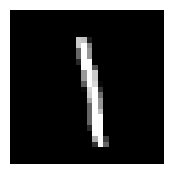

In [79]:
# get some random training images
#dataiter = iter(testloader)
images, labels = next(dataiter)
print(labels)
imshow(torchvision.utils.make_grid(images))

In [80]:
_, pred = net(images)
torch.argmax(pred, dim=1)

tensor([1])